In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import math
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Preparation of the LoS tables
## Saves LoS attribtute price for cars
## Needs shortest paths of the the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(model_path + 'de_road_los')
z = stepmodel.read_json(model_path + 'de_zones')
sm.zones = z.zones

## Add cost to LoS table

In [7]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

Take only perceived variable cost for distance-dependency.<br>
Assume monthly mileage of 15,000km / 12<br>

Instead of fix cost per trip, one can also assume ownership cost per hour of vehicle usage. This is also the approach chosen for the German federal governments transport study. In the methodical handbook gasoline cars have engine class weighted specific ownership cost of 0.71 EUR/h and diesel cars 0.99 EUR/h (other propulsion systems don't play a significant role). Multiplied with 2017's shares of gasoline and diesel cars (66.5%; 33.5%) this yields weighted average ownership cost of 0.8 EUR/h.

In [8]:
# Prep
parking_cost = params['parking_cost']
car_occ = params['car_occ']
urb_dict = sm.zones['urbanisation'].to_dict()

In [9]:
# Scale time to hours
if sm.car_los['time'].mean() > 3600:
    sm.car_los['time'] = sm.car_los['time'] / 3600
assert sm.car_los['time'].mean() < 10
sm.car_los['time'].mean()

4.239213813569879

In [10]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
for seg in segments:
    vc_car = params['car_var_cost'][seg]
    fix_car = params['car_fix_cost'][seg]
    sm.car_los[seg+'_price'] = sm.car_los.apply(
        lambda df: monetary_cost(
        df['length']/1000, 1, vc_car,
        0,0, # parking at home is for free
        parking_cost[int(urb_dict[df['destination']])], 1,
        car_occ[seg])
        + fix_car * df['time'], axis=1)

In [11]:
sm.car_los.sample(2)

,origin,destination,time,link_path,access_time,in_vehicle_time,length,route_type,route_types,commuting_no_car_price,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
index,,,,,,,,,,,,,,,,,,,,,
795144,DE21H_8,DE277_5,1.747500,"[rl_73746, rl_73747, rl_372615, rl_373543, rl_...",300,5991,120413,car,[car],69.976111,...,74.083579,10.595656,76.565076,7.445596,58.352116,7.738401,46.605899,5.861427,48.725399,5.139684
624566,DE217_9,DEA2D_2,5.481111,"[rl_67925, rl_69289, rl_69291, rl_371392, rl_6...",300,19432,621760,car,[car],343.614927,...,364.824092,54.711328,377.637454,38.445798,283.593704,39.957712,222.941386,30.265841,233.885556,26.539077


<AxesSubplot:xlabel='length'>

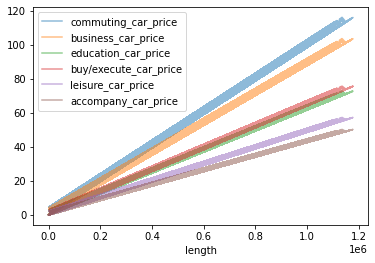

In [12]:
sm.car_los.set_index('length')[[s+'_price' for s in segments if len(s.split('_'))<3]].plot(alpha=.5)

## Save model

In [13]:
# Make table smaller
cols = ['access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [14]:
sm.to_json(model_path + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 9/9 [04:32<00:00, 30.23s/it]
